# Project 6: Develop an automatic classification engine for consumer goods.
*Pierre-eloi Ragetly*

This project is part of the Data Scientist path proposed by OpenClassrooms.



In [1]:
# Import usual libraries
import numpy as np
import pandas as pd
import os
import time
import re

# to make this notebook's output stable across runs
np.random.seed(89)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'axes.titleweight': 'bold',
                     'axes.titlesize': 16,
                     'axes.labelsize': 14,
                     'xtick.labelsize': 12,
                     'ytick.labelsize': 12})

# Where to save the figures
def save_fig(fig_id, tight_layout=True):
    folder_path = os.path.join("charts")
    if not os.path.isdir(folder_path):
        os.makedirs(folder_path)
    path = os.path.join("charts", fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Natural-Language-Processing-(NLP)" data-toc-modified-id="Natural-Language-Processing-(NLP)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Natural Language Processing (NLP)</a></span><ul class="toc-item"><li><span><a href="#Text-preprocessing" data-toc-modified-id="Text-preprocessing-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Text preprocessing</a></span><ul class="toc-item"><li><span><a href="#Lower-casing" data-toc-modified-id="Lower-casing-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Lower casing</a></span></li><li><span><a href="#Tokenization" data-toc-modified-id="Tokenization-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Tokenization</a></span></li><li><span><a href="#Stop-words-removal" data-toc-modified-id="Stop-words-removal-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Stop words removal</a></span></li><li><span><a href="#Lemmatization" data-toc-modified-id="Lemmatization-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Lemmatization</a></span></li><li><span><a href="#Preprocessing-pipeline" data-toc-modified-id="Preprocessing-pipeline-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Preprocessing pipeline</a></span></li></ul></li><li><span><a href="#Feature-extraction" data-toc-modified-id="Feature-extraction-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Feature extraction</a></span><ul class="toc-item"><li><span><a href="#Bag-of-words" data-toc-modified-id="Bag-of-words-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Bag of words</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>TF-IDF</a></span></li><li><span><a href="#Word-Embedding-with-Word2Vec" data-toc-modified-id="Word-Embedding-with-Word2Vec-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Word Embedding with Word2Vec</a></span></li></ul></li><li><span><a href="#Dimension-reduction" data-toc-modified-id="Dimension-reduction-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Dimension reduction</a></span><ul class="toc-item"><li><span><a href="#Latent-Dirichlet-Allocation-(LDA)" data-toc-modified-id="Latent-Dirichlet-Allocation-(LDA)-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Latent Dirichlet Allocation (LDA)</a></span></li><li><span><a href="#Non-negative-Matrix-Factorization-(NMF)" data-toc-modified-id="Non-negative-Matrix-Factorization-(NMF)-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Non-negative Matrix Factorization (NMF)</a></span></li><li><span><a href="#K-means" data-toc-modified-id="K-means-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>K-means</a></span><ul class="toc-item"><li><span><a href="#with-Bag-of-words" data-toc-modified-id="with-Bag-of-words-1.3.3.1"><span class="toc-item-num">1.3.3.1&nbsp;&nbsp;</span>with Bag-of-words</a></span></li><li><span><a href="#with-TF-IDF" data-toc-modified-id="with-TF-IDF-1.3.3.2"><span class="toc-item-num">1.3.3.2&nbsp;&nbsp;</span>with TF-IDF</a></span></li><li><span><a href="#with-Word2Vec" data-toc-modified-id="with-Word2Vec-1.3.3.3"><span class="toc-item-num">1.3.3.3&nbsp;&nbsp;</span>with Word2Vec</a></span></li></ul></li><li><span><a href="#Agglomerative-Clustering-(Ward)" data-toc-modified-id="Agglomerative-Clustering-(Ward)-1.3.4"><span class="toc-item-num">1.3.4&nbsp;&nbsp;</span>Agglomerative Clustering (Ward)</a></span><ul class="toc-item"><li><span><a href="#with-bag-of-words" data-toc-modified-id="with-bag-of-words-1.3.4.1"><span class="toc-item-num">1.3.4.1&nbsp;&nbsp;</span>with bag-of-words</a></span></li><li><span><a href="#with-TF-IDF" data-toc-modified-id="with-TF-IDF-1.3.4.2"><span class="toc-item-num">1.3.4.2&nbsp;&nbsp;</span>with TF-IDF</a></span></li><li><span><a href="#with-Word2Vec" data-toc-modified-id="with-Word2Vec-1.3.4.3"><span class="toc-item-num">1.3.4.3&nbsp;&nbsp;</span>with Word2Vec</a></span></li></ul></li></ul></li><li><span><a href="#Data-Visualization" data-toc-modified-id="Data-Visualization-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Data Visualization</a></span></li></ul></li><li><span><a href="#Computing-Vision" data-toc-modified-id="Computing-Vision-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Computing Vision</a></span><ul class="toc-item"><li><span><a href="#Bag-of-features" data-toc-modified-id="Bag-of-features-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Bag-of-features</a></span><ul class="toc-item"><li><span><a href="#SIFT" data-toc-modified-id="SIFT-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>SIFT</a></span></li><li><span><a href="#Visual-Words" data-toc-modified-id="Visual-Words-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Visual Words</a></span></li><li><span><a href="#Visual-Words-histogram" data-toc-modified-id="Visual-Words-histogram-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Visual Words histogram</a></span></li><li><span><a href="#bag-of-features-pipeline" data-toc-modified-id="bag-of-features-pipeline-2.1.4"><span class="toc-item-num">2.1.4&nbsp;&nbsp;</span>bag-of-features pipeline</a></span></li></ul></li><li><span><a href="#Images-clustering" data-toc-modified-id="Images-clustering-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Images clustering</a></span></li><li><span><a href="#Tansfer-learning" data-toc-modified-id="Tansfer-learning-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Tansfer learning</a></span></li></ul></li><li><span><a href="#Clustering-with-all-data" data-toc-modified-id="Clustering-with-all-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Clustering with all data</a></span></li></ul></div>

# Get data

In [2]:
data = (pd.read_csv("data/Flipkart/flipkart_com-ecommerce_sample_1050.csv")
          .set_index('uniq_id'))

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1050 entries, 55b85ea15a1536d46b7190ad6fff8ce7 to f2f027ad6a6df617c9f125173da71e44
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   crawl_timestamp          1050 non-null   object 
 1   product_url              1050 non-null   object 
 2   product_name             1050 non-null   object 
 3   product_category_tree    1050 non-null   object 
 4   pid                      1050 non-null   object 
 5   retail_price             1049 non-null   float64
 6   discounted_price         1049 non-null   float64
 7   image                    1050 non-null   object 
 8   is_FK_Advantage_product  1050 non-null   bool   
 9   description              1050 non-null   object 
 10  product_rating           1050 non-null   object 
 11  overall_rating           1050 non-null   object 
 12  brand                    712 non-null    object 
 13  product_specifications  

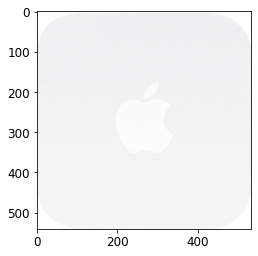

In [4]:
from PIL import Image

img = Image.open("data/Flipkart/Images/" + data.image[343])
plt.imshow(img)
plt.show()

The product number *9743e6d1c9f3180483825fe4d2e97836* (index 343), does not have any image. It must be dicarded.

In [5]:
data.drop(data.index[343], axis='index', inplace=True)

Let's start by extracting the category of each product. For this, we will use the *product_category_tree* feature and will keep the first level only with a regular expression.

In [6]:
regex = r'^\["(.+?) >>'
categories = (pd.Series(data['product_category_tree'])
                .apply(lambda x: re.findall(regex, x)[0]))

The most promising attribute to automate the goods classification is the *description* feature, gathering text data. The problem with modeling text is that it is *messy*, while machine learning algorithms prefer well defined fixed-length inputs and outputs. Therefore, these algorithms cannot learn from the raw text directly, the latter must be previously converted into vectors of numbers. Let's see how it can be carried out.

## Natural Language Processing (NLP)

As previously said, before using any Machine Learning on text, the latter must be transformed into something an algorithm can digest: vectors of numbers. This process is called Natural Language Processing (NLP) and includes two sequential steps:
1. Text Preprocessing
2. Feature extraction

The first one provides a clean and normalize dataset, while the second one converts the prepared text to a vector of numbers.

### Text preprocessing

Text preprocessing, or data nomalization, is a process of converting data from the initial raw form into a format more suitable for further analysis.
Since data are text and not numbers, we will not use the same techniques that for a classic data wrangling.  
The most common ones used to prepare text data are listed below:
- Lower casing &ndash; convert a word to lower case;
- Tokenization &ndash; convert sentences to words;
- Remove unnecessary punctuation, numbers;
- Remove **stop words** &ndash; frequent words such as "the", "a", "is";
- Use **Stemming** or **Lemmatization** to convert a word to its root/base form.

#### Lower casing

Two words like Text and text, meaning exactly the same, will be considered as two different words. Consequently, it is highly adviced to convert all words to lower case before carring out any text pre-processing.

In [7]:
corpus = data['description'].copy().str.lower()

#### Tokenization

Tokenization is defined as a process to split the text into smaller unit, i.e. tokens. The easiest way is white space tokenization, meaning split the text based on whitespace between two words.  
One of the most used function is `word_tokenize()` from the *NLTK* (Natural Language ToolKit) python library. This function splits tokens based on white space and some punctuation marks such as `.` or `'`, but **not all** of them. Moreover, the methodology used to split contractions like "isn't" depends on the contraction itself and may make the stop words removal process (see section 1.1.4) really painful. For these reasons, it is much more prefered to use **regular expressions** (regex) and split the text by keeping alphanumeric characters only.

In [8]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\b\w+\b')
tokens = (pd.Series(corpus)
            .apply(tokenizer.tokenize))

We can slightly change the regular expression to only keep letters and so, exclude numbers which are not of any interest here.

In [9]:
tokenizer = RegexpTokenizer(r'\b[a-zA-Z]+\b')
tokens = (pd.Series(corpus)
            .apply(tokenizer.tokenize))

#### Stop words removal

*Stop words* are words that do not contribute to the deeper meaning of the sentence and so, do not really help to distinguish two different documents. Worse, they bring noise and may drop significantly the performance of the model. For this reason, they should be removed.   
Stop words usually refer to the **most common** words such as "and", "the" or "a". But there is no *single universal list* of stopwords. The stop words list may change depending on the application.  

To illustrate the importance of removing stop words, let's see what are the top 10 most used words before removing the stop words.

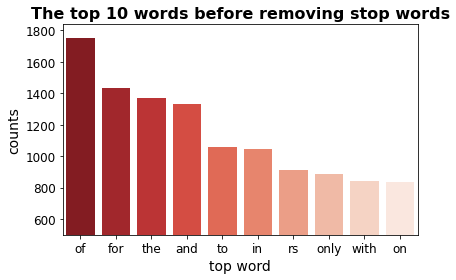

In [10]:
from nltk import FreqDist

words_flat = list(np.concatenate(tokens.values, axis=None))
frequency = FreqDist(words_flat)
top_words = sorted(frequency, key=frequency.__getitem__, reverse=True)[:10]
counts = [frequency[k] for k in top_words]
# Create the plot
sns.barplot(x=top_words, y=counts, palette='Reds_r')
plt.title("The top 10 words before removing stop words")
plt.ylim(bottom=500)
plt.xlabel("top word")
plt.ylabel("counts")
save_fig("Top_words_before_removing_stop-words")
plt.show()

All top words beyond "only" and "rs" (standing for indian rupees) are determiners, prepositions or conjunctions, and so clearly not help for finding the category of each product. Even "only" and "rs" do not realy help.  
Let's compare now with the top word obtained after removing the stop words.

As for tokenization, NLTK provides a list of common stop words for a variety of languages, such as English. This list can be found in the `stopwords` package. We will add the word "rs" to that list.

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

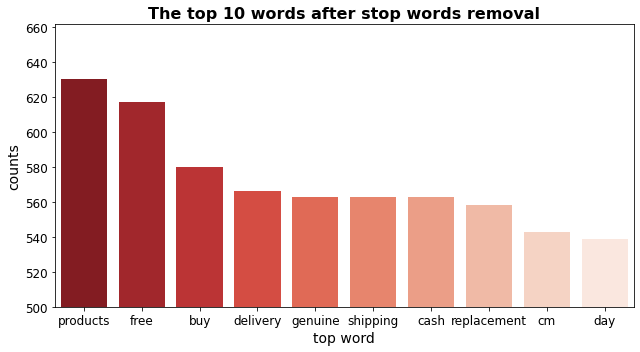

In [11]:
from nltk.corpus import stopwords

# Build the stop words corpus
stop_words = stopwords.words('english')
print(stop_words)
stop_words.append("rs")

# filter out stop words
words = tokens.copy()
for i in range(len(words)):
    words.iloc[i] = [w for w in words.iloc[i]
                     if not w in stop_words]
    
# Get word frequencies
words_flat = list(np.concatenate(words.values, axis=None))
frequency = FreqDist(words_flat)
top_words = sorted(frequency, key=frequency.__getitem__, reverse=True)[:10]
counts = [frequency[k] for k in top_words]

# Plot top words
plt.figure(figsize=(9, 5))
sns.barplot(x=top_words, y=counts, palette='Reds_r')
plt.title("The top 10 words after stop words removal")
plt.ylim(bottom=500)
plt.xlabel("top word")
plt.ylabel("counts")
save_fig("Top_words_after_removing_stop-words")
plt.show()

It is much better, we will stop here for stop words (even if we could also remove the word "cm").

#### Lemmatization

The purpose of stemming or Lemmatization is to reduce words like "studies" to a root word ("studi") or a canonical form ("study") respectively. Though it is much more easier to develop a stemmer than a lemmatizer (which requires deep linguistics knowledge to build the lemma of each word), the latter is prefered. The noise will be more reduced and so, the results provided more accurate. We will use the `wordnet` class.

In [12]:
from nltk.corpus import wordnet as wn

def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
for i in range(len(words)):
    words.iloc[i] = [get_lemma(w)
                     for w in words[i]]

#### Preprocessing pipeline 

All steps previously presented have been gathered in a pipeline. To avoid words such as "rs" or "cm, the regular expression has been slightly changed. In this pipeline, the latter selects tokens of 3 or more characters.

In [13]:
def prepare_text(text):
    """Function to prepare text before realizing NLP.
    It includes the following steps:
    1. Lower Casing
    2. Tokenization (with regex exluding numbers and punctuations)
    3. Stop words removal
    4. Lemmatization"""
    tokenizer = RegexpTokenizer(r'\b[a-zA-Z]{3,}\b')
    tokens = tokenizer.tokenize(text.lower())
    stop_words = stopwords.words('english')
    tokens = [token for token in tokens
              if not token in stop_words]
    tokens = [get_lemma(token)
              for token in tokens]
    return tokens

In [14]:
corpus = pd.Series(data['description'])
for i, text in enumerate(corpus):
    corpus.iloc[i] = prepare_text(text)

### Feature extraction

In text processing, words represent **discrete, categorical features**. These kind of features cannot be directly used by a machine learning algorithm, and must be before encoded into vectors of numbers. This process is called **feature extraction**.

#### Bag of words

One of the most popular and simplest feature extraction technique is likely the **bag-of-words** model. This model counts the occurence of each word within a document. Any information about **the order**, **grammar** or **structure** of words is discarded, only the multiplicity is kept. That is why actually, it is called a **bag** of words.

The main assumption **is that similar documents have similar contents** and so, the content may learn something about the meaning of the document to us.

The bag-of-word involves two steps:
1. Build a vocabulary with all the unique words present in the data provided;
2. Count the occurence of the known words for each document.

The result is a $(m, p)$ **sparse** array with $m$ the number of documents and $p$ the number of words present in the corpus.  
To get this array we can use the class `CountVectorizer` from the `sklearn.feature_extraction.text` package. This class enables **text preprocessing** in addition of **feature extraction**. However, some fancy analysis such as *stemming* or *lemmatizing* are **not included**, for this reason we will use our **prepared dataset** (got with the pipeline detailed above) intead of raw data by passing `analyzer=str.split`. Note that prepared data must be stored with tokens **separated by whitespace** and not as a list of tokens.

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

# Store clean data with tokens separated by whitespace
corpus_whitespace = [" ".join(tokens) for tokens in corpus]

# Convert text into vectors of numbers
vect_bow = CountVectorizer(analyzer=str.split)
X_bow = vect_bow.fit_transform(corpus_whitespace)
n = len(vect_bow.get_feature_names())
print("Number of unique words in the corpus: {}".format(n))

Number of unique words in the corpus: 4169


#### TF-IDF

One problem with scoring word frequency &ndash; like the *bag-of-words* does &ndash; is that the most frequent words in the english language will have a high score for each document. Removing the stop of words reduces the problem, but does not solve it totally.  
These frequent words may not content as much **information gain** to the model compared with some rarer and domain-specific words. One approach to fix that problem is to penalize words that are **frequent across all the documents**. the **TF-IDF** technique, standing for Term Frequency - Inverse Document Frequency, is based on this approach.

Let' see what TF and IDF mean:
- Term Frequency (TF) = Number of times a term $t$ appears in the document $/$ Total number of terms in this document
- Inverse Document Frequency (IDF) = $log($Number of documents $/$ number of documents containing the $t$ term$)$

$$\text{score(t)} = \text{tf(t)} \times log\left( \frac{n}{\text{df(t)}} \right)$$

As for *the bag-of-words*, we can use the `sklearn.feature_extraction.text` package and its `TfidfVectorizer` class to calculate the TF-IDF scores. Please note that in the sklearn library, the idf computing differs slightly from the standard textbook: a $1$ count is added to the idf to make sure terms with zero idf (when df(t) = $n$) do not be suppressed entirely.
$$\text{idf(t)}= log\left( \frac{n + \text{smooth_idf}}{\text{df(t)} + \text{smooth_idf}} \right) + 1$$
The parameter $\text{smooth_idf}$ is a boolean (takes only 2 values: 1 or 0). preventing zero divisions. When $\text{smooth_idf}$ = 1, it is as if an extra document containing all words of the vocabulary was added to the corpus.  
By construction, only words present in at least one document can be added to the vocabulary, so the zero division should not occur. That is why, it was prefered to use the *False* (0) value for this parameter.

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text into vectors of numbers with TF-IDF
vect_tfidf = TfidfVectorizer(analyzer=str.split,
                             smooth_idf=False)
X_tfidf = vect_tfidf.fit_transform(corpus_whitespace)

#### Word Embedding with Word2Vec

Techniques based on word frequency like the Bag of words or TF-IDF suffer from two majors problems:
1. dimensionality problem: the more documents you have the larger is the vocabulary, so the feature matrix will be a huge sparse matrix;
2. They ignore the context by discarding word order. As a consequence, the distance between vectors doesn't always reflect the difference in meaning.

New techniques have been developed early 2010's to address both problems. These techniques, called **Word Embedding**, use another approach based on the **distributional hypothesis**:

*linguisic items with similar distribution have similar meanings.*

They produce a **vector space** (with a number of dimensions between tens to hundreds) where each word from the vocabulary are represented by vectors of real numbers. These vectors are calculated from the probability distribution for each word appearing **before** or **after** another.

In other words, as words of the same context usually appear together in the corpus, they will be located close to one another in the vector space as well. 

Most popular Word Embedding models are:
- Google's **Word2Vec** (2013)
- Stanford's **Glove** (2014)
- Facebook's **FastText** (2016)

We will choose **Word2Vec** which uses neural networks with a single hidden layer to map text to vectors. The vector space dimension is determined by the number of neurons in the hidden layer, and the *word vector* is merely the weights of these neurons. Two different architectures can be used:
- **Continuous Bag of Words** (CBOW)
- **Skip-Gram**

*CBOW* is the most used. This model tries to predict a target word based on the words surrounding it. These neighboring words are determined by a predefined *window* size (a hyper-parameter) surrounding the target words, the formers represent the **context**. As for the bag-of-words, the order of context words does not have any influcence on the prediction.  
The *Skip-Gram* model does the **opposite**. Here, target word is input while context words are output. As there are more than one context word to be predicted, skip-gram is slower and harder to be trained. However, it does better job for infrequent words.

As our dataset is very limited, we will a use **pre-trained** model instead of training our own one. The `Gensim` Python library is a very popular NLP library, and makes NLP models such as Word2Vec very easy to use. Let's see which pre-trained models are included in this library.

In [17]:
import gensim.downloader as api

for i, model in enumerate(api.info()['models']):
    description = api.info()['models'][model]['description']
    print("{}. {}: {}".format(i+1, model, description))

1. fasttext-wiki-news-subwords-300: 1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).
2. conceptnet-numberbatch-17-06-300: ConceptNet Numberbatch consists of state-of-the-art semantic vectors (also known as word embeddings) that can be used directly as a representation of word meanings or as a starting point for further machine learning. ConceptNet Numberbatch is part of the ConceptNet open data project. ConceptNet provides lots of ways to compute with word meanings, one of which is word embeddings. ConceptNet Numberbatch is a snapshot of just the word embeddings. It is built using an ensemble that combines data from ConceptNet, word2vec, GloVe, and OpenSubtitles 2016, using a variation on retrofitting.
3. word2vec-ruscorpora-300: Word2vec Continuous Skipgram vectors trained on full Russian National Corpus (about 250M words). The model contains 185K words.
4. word2vec-google-news-300: Pre-trained vectors trained on a part of

There is only one word2vec model trained on an english corpus:

**word2vec-google-news-300**.

So, we will use this one.

The main limitation of Word2Vec is that the model is unable to infer vectors for **unfamiliar** words. If it may be problematic, then it would be better to use **FastText** instead.  
Here, all words that were not included in the pre-trained model have been discarded.

Afer having encoded all words with Word2Vec, we merely need to calculate the **centroid** to encode the whole document by just one vector. This document vector have the same dimension than the word vectors (300).

In [18]:
def feature_extraction_w2v(w2v, tokens):
    # Keep only words for which it is possible to infer a vector
    words_to_del = []
    for t in tokens:
        try:
            w2v[t]
        except KeyError:
            if t not in words_to_del:
                words_to_del.append(t)
    tokens = [t for t in tokens
              if t not in words_to_del]
    # Get word vectors
    m = len(tokens)
    p = w2v.vector_size
    X = np.zeros((m, p))
    for i, t in enumerate(tokens):
        X[i] = w2v[t]
    return np.mean(X, axis=0) # return the centroid         

In [19]:
w2v = api.load('word2vec-google-news-300')

m = len(corpus)
corpus_w2v = []
for i in range(m):
    corpus_w2v.append(feature_extraction_w2v(w2v, corpus[i]))
X_w2v = np.array(corpus_w2v)
print(X_w2v.shape)

(1049, 300)


### Dimension reduction

Now that each description has been encoded into a vector, we can use common machine learning algorithms for dimension reduction. Let's start with the most popular in natural language processing, the **Latent Dirichlet Allocation** (LDA) model.

#### Latent Dirichlet Allocation (LDA)

The LDA model is very popular to classify documents and estimate their relevance to a set of topics. It is a generative statistical model where each document is viewed as a *mixture* of various topics. The topic distribution is assumed to have a sparse *Dirichlet prior* meaning that documents cover only a small set of topics and that topics use only a small set of words frequently. The corpus will be encoded into bag-of-words prior to run the LDA model.

We will use the class `LatentDirichletAllocation` from the `sklearn.decomposition` package.

In [20]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=7,
                                learning_method='batch',
                                random_state=42,
                                n_jobs=-1)
lda.fit(X_bow)

LatentDirichletAllocation(n_components=7, n_jobs=-1, random_state=42)

Let's see what are the topics found by LDA by listing the 10 most representative words for each one. We will try after to assign each topic to a category.

In [21]:
# display the top words for each topic
def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [22]:
n_top_words = 10
display_topics(lda,
               vect_bow.get_feature_names(),
               n_top_words)

Topic 0:
design price light gift feature product material usb size showpiece
Topic 1:
mug product quality design ceramic gift make battery color price
Topic 2:
baby girl cover warranty cotton feature specification type general fabric
Topic 3:
watch analog men product free online day buy guarantee india
Topic 4:
free delivery buy shipping cash genuine product flipkart com replacement
Topic 5:
feature box usb jewellery model laptop specification material phone type
Topic 6:
skin print cotton inch towel pack set specification package laptop


In [23]:
categories.unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

Just with top words, most of topics (all except 5) can be quite easily assigned to a category:
- topic 0 --> Beauty and Personal Care
- topic 1 --> Kitchen & Dining
- topic 2 --> Baby Care
- topic 3 --> Watches
- topic 4 --> Computers
- topic 6 --> Home Decor & Festive Needs

Let's build a function to automate the category assignment. We will compute the frequency of all categories for each topic find by the model. Then, each topic will be assigned to the category with the biggest frequency.

In [24]:
def assign_cluster(labels, mask=np.ones(1)):
    labels_unique = np.unique(labels)
    dic_cat = {}
    for label in labels_unique:
        in_label = (labels==label)
        if len(mask) > 1:
            dic_cat[label] = categories[in_label & mask].value_counts().index[0]
        else:
            dic_cat[label] = categories[in_label].value_counts().index[0] 
    return dic_cat        

In [25]:
labels_lda = lda.transform(X_bow).argsort(axis=1)[:, -1]
dic_lda = assign_cluster(labels_lda)
dic_lda

{0: 'Home Decor & Festive Needs',
 1: 'Kitchen & Dining',
 2: 'Baby Care',
 3: 'Watches',
 4: 'Computers',
 5: 'Computers',
 6: 'Baby Care'}

It seems that the LDA model was not able to identify the Home Furnishing category. Let's build a confusion matrix to see the model performance.

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


def confusion_matrix_tuned(dic, labels): 
    y_true = categories.values
    y_pred = [dic[label] for label in labels]
    cat_names = categories.sort_values().unique()
    labels_true = [cat + "_true" for cat in cat_names]
    labels_pred = [label + "_pred" for label in cat_names]
    print("accuracy: {}".format(accuracy_score(y_true, y_pred)))
    print("recall: {}".format(recall_score(y_true, y_pred,
                                           average='weighted',
                                           zero_division=0)))
    print("precision: {}".format(precision_score(y_true, y_pred,
                                                 average='weighted',
                                                zero_division=0)))
    return pd.DataFrame(confusion_matrix(y_true, y_pred),
                        columns=labels_pred,
                        index=labels_true)

In [27]:
confusion_matrix_tuned(dic_lda, labels_lda)

accuracy: 0.4022878932316492
recall: 0.4022878932316492
precision: 0.3362430228712766


,Baby Care_pred,Beauty and Personal Care_pred,Computers_pred,Home Decor & Festive Needs_pred,Home Furnishing_pred,Kitchen & Dining_pred,Watches_pred
Baby Care_true,104,0,34,3,0,4,5
Beauty and Personal Care_true,21,0,92,5,0,8,24
Computers_true,27,0,101,17,0,4,0
Home Decor & Festive Needs_true,13,0,81,37,0,10,9
Home Furnishing_true,66,0,75,2,0,7,0
Kitchen & Dining_true,16,0,71,24,0,38,1
Watches_true,2,0,2,1,0,3,142


We can also reduce the dimension to visualize all clusters in a 2D plan. The most used algorithm for clusters visualization is the *t-SNE (t-Distributed Stochastic Neighbor Embedding)*.

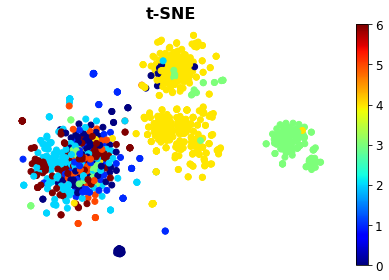

In [28]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MaxAbsScaler

# Scaling data is required before using t-SNE
scaler = MaxAbsScaler()
X_bow_scaled = scaler.fit_transform(X_bow)

# Train the t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
X_tsne = tsne.fit_transform(X_bow_scaled)

# Plot results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_lda, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.title("t-SNE")
save_fig("t-SNE_plot")
plt.show()

Result does not look good. Clusters 1, 2, 5 and 6 are overlapped. The cluster 4 seems splitted in two. Let's try another model.

#### Non-negative Matrix Factorization (NMF)

The Non-negative Matrix is another popular technique for topic modeling. As the LDA, it takes in input the word frequencies. However, the use of a bag-of-words is not required (contrary to the LDA), a TF-IDF may be realized for instance.

In [29]:
from sklearn.decomposition import NMF

nmf=NMF(n_components=7,
        init='nndsvd',
        alpha=.1,
        l1_ratio=0, # L2 penalty
        random_state=42)
nmf.fit(X_tfidf)

NMF(alpha=0.1, init='nndsvd', l1_ratio=0, n_components=7, random_state=42)

In [30]:
no_top_words = 10
display_topics(nmf,
               vect_tfidf.get_feature_names(),
               no_top_words)

Topic 0:
com flipkart guarantee replacement genuine cash shipping day delivery buy
Topic 1:
watch analog men discount india great woman sonata maximum dial
Topic 2:
mug coffee ceramic perfect tea gift prithish printland one love
Topic 3:
baby girl details cotton fabric dress boy sleeve neck shirt
Topic 4:
rockmantra ceramic mug porcelain thrill stays permanent start making years
Topic 5:
laptop warranty skin inch cover design print pack model color
Topic 6:
abstract blanket double single com flipkart quilt shipping cash genuine


Contrary to the LDA, categories are less intuitive. Let's see how each category has been assigned.

In [31]:
labels_tfidf = nmf.transform(X_bow).argsort(axis=1)[:, -1]
dic_tfidf = assign_cluster(labels_tfidf)
dic_tfidf

{0: 'Beauty and Personal Care',
 1: 'Watches',
 2: 'Kitchen & Dining',
 3: 'Baby Care',
 4: 'Kitchen & Dining',
 5: 'Home Decor & Festive Needs',
 6: 'Home Furnishing'}

This time, the *Home Furnishing* category has been identify, but not the *computer* category. Let's inspect the model performance by displaying the confusion matrix.

In [32]:
confusion_matrix_tuned(dic_tfidf, labels_tfidf)

accuracy: 0.5128693994280267
recall: 0.5128693994280267
precision: 0.5980356916321024


,Baby Care_pred,Beauty and Personal Care_pred,Computers_pred,Home Decor & Festive Needs_pred,Home Furnishing_pred,Kitchen & Dining_pred,Watches_pred
Baby Care_true,91,31,0,21,5,2,0
Beauty and Personal Care_true,5,105,0,38,0,0,2
Computers_true,0,93,0,56,0,0,0
Home Decor & Festive Needs_true,1,76,0,66,1,6,0
Home Furnishing_true,8,23,0,57,62,0,0
Kitchen & Dining_true,0,36,0,42,0,72,0
Watches_true,0,4,0,4,0,0,142


Results looks much better than the ones get with the LDA model. Let's see the result with t-SNE.

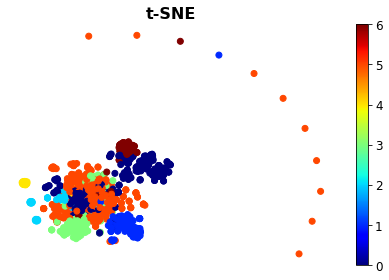

In [33]:
# Scaling data is required before using t-SNE
X_tfidf_scaled = scaler.fit_transform(X_tfidf)

# Train the t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
X_tsne = tsne.fit_transform(X_tfidf_scaled )

# Plot results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_tfidf, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.title("t-SNE")
save_fig("t-SNE_plot")
plt.show()

The t-SNE looks also better, but we have still too much overlap. Let's try clustering algorithms.

#### K-means

In [34]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=42)

In [35]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()

##### with Bag-of-words

In [36]:
# Train the K-Means
labels_km_bow = kmeans.fit(X_bow_scaled).labels_
# Assign each cluster with a category
dic_km_bow = assign_cluster(labels_km_bow)
# Get the confusion matrix
confusion_matrix_tuned(dic_km_bow, labels_km_bow)

accuracy: 0.36415633937082936
recall: 0.36415633937082936
precision: 0.3072286053300361


,Baby Care_pred,Beauty and Personal Care_pred,Computers_pred,Home Decor & Festive Needs_pred,Home Furnishing_pred,Kitchen & Dining_pred,Watches_pred
Baby Care_true,116,0,27,0,0,0,7
Beauty and Personal Care_true,49,0,22,0,0,0,79
Computers_true,49,0,100,0,0,0,0
Home Decor & Festive Needs_true,74,0,76,0,0,0,0
Home Furnishing_true,76,0,74,0,0,0,0
Kitchen & Dining_true,67,0,49,0,0,32,2
Watches_true,16,0,0,0,0,0,134


The results are quite disappointing. The problem may be that we incoporate all the instances to assign the category to each label; including the instances located close to the cluster boundaries, which are more likely to be mislabeled. Let's see what happens if we only use the instances close to one centroid. Another function will be created to test various percentage of the instances, the best percentage will be returned.

In [37]:
def mask_closest(X, model, percentile=20):
    X_tr = model.transform(X)
    n_clusters = X_tr.shape[1]
    X_cluster_dist = X_tr[np.arange(len(X_tr)), model.labels_]
    for i in range(n_clusters - 1):
        in_cluster = (model.labels_ == i)
        cluster_dist = X_cluster_dist[in_cluster]
        cutoff = np.percentile(cluster_dist, percentile)
        above_cutoff = (X_cluster_dist > cutoff)
        X_cluster_dist[in_cluster & above_cutoff] = -1
    return (X_cluster_dist > 0)

In [38]:
def best_percentile(X, model):
    accuracy_scores = np.zeros(10)
    percentile_values = np.linspace(10, 100, 10)
    for i, p in enumerate(percentile_values):
        mask = mask_closest(X, model, percentile=p)
        dic = assign_cluster(model.labels_, mask)
        y_true = categories.values
        y_pred = [dic[label] for label in model.labels_]
        accuracy_scores[i] = accuracy_score(y_true, y_pred)
    return percentile_values[np.argmax(accuracy_scores)]

In [39]:
percentile = best_percentile(X_bow_scaled, kmeans)
print("the best percentile is: {:.0f}".format(percentile))
mask = mask_closest(X_bow_scaled, kmeans, percentile)
dic_km_bow = assign_cluster(kmeans.labels_, mask)
# Get the confusion matrix
confusion_matrix_tuned(dic_km_bow, kmeans.labels_)

the best percentile is: 30
accuracy: 0.36415633937082936
recall: 0.36415633937082936
precision: 0.3072286053300361


,Baby Care_pred,Beauty and Personal Care_pred,Computers_pred,Home Decor & Festive Needs_pred,Home Furnishing_pred,Kitchen & Dining_pred,Watches_pred
Baby Care_true,116,0,27,0,0,0,7
Beauty and Personal Care_true,49,0,22,0,0,0,79
Computers_true,49,0,100,0,0,0,0
Home Decor & Festive Needs_true,74,0,76,0,0,0,0
Home Furnishing_true,76,0,74,0,0,0,0
Kitchen & Dining_true,67,0,49,0,0,32,2
Watches_true,16,0,0,0,0,0,134


It is more or less the same, results are still poor. Let's see t-SNE.

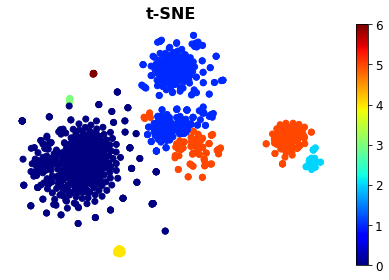

In [40]:
# Train the t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
X_tsne = tsne.fit_transform(X_bow_scaled)

# Plot results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.title("t-SNE")
save_fig("t-SNE_plot")
plt.show()

The t-SNE result is more promising.

##### with TF-IDF

In [41]:
# Scale data
X_tfidf_scaled = scaler.fit_transform(X_tfidf)
# Train the K-Means
labels_km_tfidf = kmeans.fit(X_tfidf_scaled).labels_
# Assign each cluster with a category
percentile = best_percentile(X_tfidf_scaled, kmeans)
print("the best percentile is: {:.0f}".format(percentile))
mask = mask_closest(X_tfidf_scaled, kmeans, percentile)
dic_km_tfidf = assign_cluster(kmeans.labels_, mask)
# Get the confusion matrix
confusion_matrix_tuned(dic_km_tfidf, labels_km_tfidf)

the best percentile is: 100
accuracy: 0.4489990467111535
recall: 0.4489990467111535
precision: 0.540898870169518


,Baby Care_pred,Beauty and Personal Care_pred,Computers_pred,Home Decor & Festive Needs_pred,Home Furnishing_pred,Kitchen & Dining_pred,Watches_pred
Baby Care_true,75,20,0,14,0,41,0
Beauty and Personal Care_true,0,77,0,24,0,49,0
Computers_true,0,66,10,26,0,47,0
Home Decor & Festive Needs_true,0,0,0,76,0,74,0
Home Furnishing_true,12,74,0,0,0,64,0
Kitchen & Dining_true,0,3,0,48,0,99,0
Watches_true,6,0,0,0,0,10,134


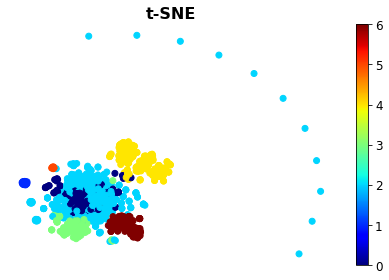

In [42]:
# Train the t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
X_tsne = tsne.fit_transform(X_tfidf_scaled)

# Plot results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.title("t-SNE")
save_fig("t-SNE_plot")
plt.show()

##### with Word2Vec

In [43]:
# Scale data
X_w2v_scaled = scaler.fit_transform(X_w2v)
# Train the K-Means
labels_km_w2v = kmeans.fit(X_w2v_scaled).labels_
# Assign each cluster with a category
percentile = best_percentile(X_w2v_scaled, kmeans)
print("the best percentile is: {:.0f}".format(percentile))
mask = mask_closest(X_w2v_scaled, kmeans, percentile)
dic_km_w2v = assign_cluster(kmeans.labels_, mask)
# Get the confusion matrix
confusion_matrix_tuned(dic_km_w2v, labels_km_w2v)

the best percentile is: 10
accuracy: 0.561487130600572
recall: 0.561487130600572
precision: 0.6082726333514824


,Baby Care_pred,Beauty and Personal Care_pred,Computers_pred,Home Decor & Festive Needs_pred,Home Furnishing_pred,Kitchen & Dining_pred,Watches_pred
Baby Care_true,95,20,0,31,0,2,2
Beauty and Personal Care_true,2,80,2,66,0,0,0
Computers_true,0,69,76,4,0,0,0
Home Decor & Festive Needs_true,0,0,1,139,0,8,2
Home Furnishing_true,19,74,0,57,0,0,0
Kitchen & Dining_true,0,3,1,83,0,63,0
Watches_true,0,0,2,12,0,0,136


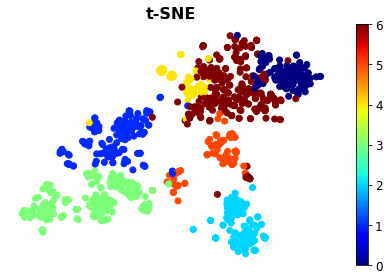

In [44]:
# Train the t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
X_tsne = tsne.fit_transform(X_w2v_scaled)

# Plot results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.title("t-SNE")
save_fig("t-SNE_plot")
plt.show()

That is much better, we can clearly identify each cluster.

#### Agglomerative Clustering (Ward)

In [45]:
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering

def ward_model(X, n_clusters):
    # Connectivity matrix
    connectivity = kneighbors_graph(X, n_neighbors=25,
                                    include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    # Create the ward model
    ward = AgglomerativeClustering(n_clusters,
                                   linkage='ward',
                                   connectivity=connectivity)
    return ward

##### with bag-of-words

In [46]:
# Train the ward model
ward_bow = ward_model(X_bow_scaled, 7)
labels_ward_bow = ward_bow.fit(X_bow_scaled.toarray()).labels_
# Assign each cluster with a category
dic_ward_bow = assign_cluster(labels_ward_bow)
# Get the confusion matrix
confusion_matrix_tuned(dic_ward_bow, labels_ward_bow)

accuracy: 0.38322211630123926
recall: 0.38322211630123926
precision: 0.49982334157739305


,Baby Care_pred,Beauty and Personal Care_pred,Computers_pred,Home Decor & Festive Needs_pred,Home Furnishing_pred,Kitchen & Dining_pred,Watches_pred
Baby Care_true,116,34,0,0,0,0,0
Beauty and Personal Care_true,49,101,0,0,0,0,0
Computers_true,49,93,7,0,0,0,0
Home Decor & Festive Needs_true,74,76,0,0,0,0,0
Home Furnishing_true,76,74,0,0,0,0,0
Kitchen & Dining_true,55,51,0,0,0,44,0
Watches_true,16,0,0,0,0,0,134


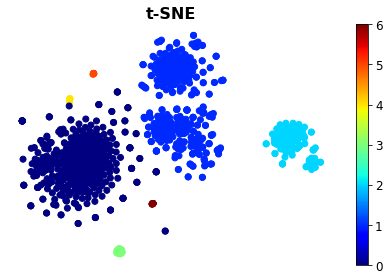

In [47]:
# Train the t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
X_tsne = tsne.fit_transform(X_bow_scaled)

# Plot results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_ward_bow, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.title("t-SNE")
save_fig("t-SNE_plot")
plt.show()

##### with TF-IDF

In [48]:
# Train the ward model
ward_tfidf = ward_model(X_tfidf_scaled, 7)
labels_ward_tfidf = ward_tfidf.fit(X_tfidf_scaled.toarray()).labels_
# Assign each cluster with a category
dic_ward_tfidf = assign_cluster(labels_ward_tfidf)
# Get the confusion matrix
confusion_matrix_tuned(dic_ward_tfidf, labels_ward_tfidf)

accuracy: 0.432793136320305
recall: 0.432793136320305
precision: 0.4300416039581565


,Baby Care_pred,Beauty and Personal Care_pred,Computers_pred,Home Decor & Festive Needs_pred,Home Furnishing_pred,Kitchen & Dining_pred,Watches_pred
Baby Care_true,116,20,0,14,0,0,0
Beauty and Personal Care_true,49,80,0,21,0,0,0
Computers_true,55,67,0,27,0,0,0
Home Decor & Festive Needs_true,71,0,0,79,0,0,0
Home Furnishing_true,75,75,0,0,0,0,0
Kitchen & Dining_true,53,3,0,50,0,44,0
Watches_true,15,0,0,0,0,0,135


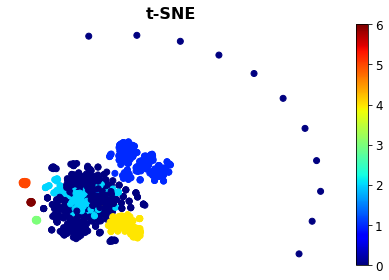

In [49]:
# Train the t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
X_tsne = tsne.fit_transform(X_tfidf_scaled)

# Plot results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_ward_tfidf, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.title("t-SNE")
save_fig("t-SNE_plot")
plt.show()

##### with Word2Vec

In [50]:
# Train the ward model
ward_w2v = ward_model(X_w2v_scaled, 7)
labels_ward_w2v = ward_w2v.fit(X_w2v_scaled).labels_
# Assign each cluster with a category
dic_ward_w2v = assign_cluster(labels_ward_w2v)
# Get the confusion matrix
confusion_matrix_tuned(dic_ward_w2v, labels_ward_w2v)

accuracy: 0.6015252621544328
recall: 0.6015252621544328
precision: 0.7178471055130252


,Baby Care_pred,Beauty and Personal Care_pred,Computers_pred,Home Decor & Festive Needs_pred,Home Furnishing_pred,Kitchen & Dining_pred,Watches_pred
Baby Care_true,89,0,0,14,20,27,0
Beauty and Personal Care_true,0,80,2,5,0,63,0
Computers_true,0,67,75,0,0,7,0
Home Decor & Festive Needs_true,0,0,1,75,0,72,2
Home Furnishing_true,0,1,0,0,73,76,0
Kitchen & Dining_true,0,3,1,50,1,95,0
Watches_true,0,0,1,0,0,5,144


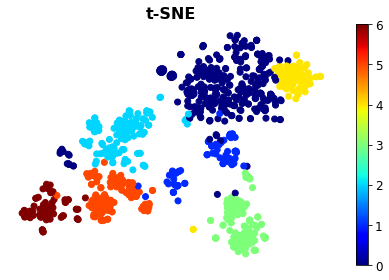

In [51]:
# Train the t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
X_tsne = tsne.fit_transform(X_w2v_scaled)

# Plot results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_ward_w2v, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.title("t-SNE")
save_fig("t-SNE_plot")
plt.show()

**We have a winner, Ward + Word2Vec model**

### Data Visualization

Let's visualize each cluster by drawing a **word cloud**.  
Creating a word cloud is a good method to visualize the corpus. It consists in randomly placing words on a canvas, with sizes proportional to their frequency.  
The `wordcloud` package enables to create it very easily. Let's build a word cloud for each cluster.

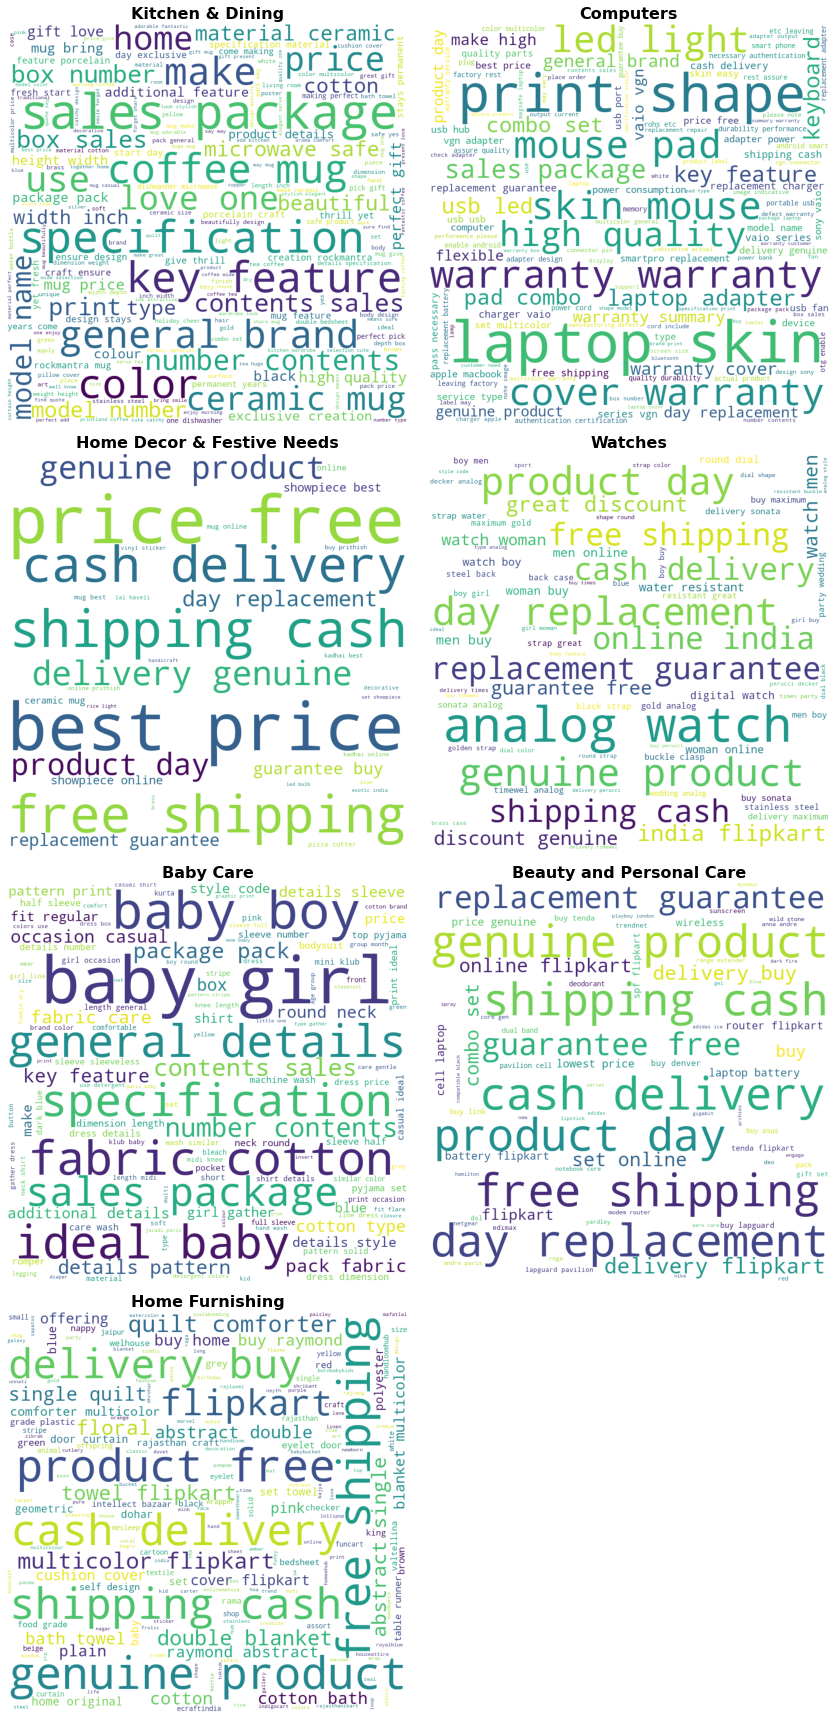

In [52]:
from wordcloud import WordCloud

# Word cloud setup
wordcloud = WordCloud(width = 800, height = 800,
                      background_color='white',
                      min_font_size=10)
# Create the figure
fig = plt.figure(figsize=(12, 24))
# Generate the word clouds
for k in range(7):
    ax = fig.add_subplot(4, 2, k+1)
    mask = (labels_ward_w2v==k)
    words_flat = list(np.concatenate(corpus[mask].values, axis=None))
    text = " ".join(words_flat)
    wordcloud.generate(text)
    ax.imshow(wordcloud)
    ax.set_title(dic_ward_w2v[k])
    ax.axis("off")

# Plot and save the word clouds
#plt.tight_layout(w_pad=0.5)
save_fig("WordCloud")
plt.show()

## Computing Vision

### Bag-of-features

Let's now process the image data. As for text, the machine learning algorithms cannot directly learn from this kind of data. We will use a technique very similar to the Bag-of-words called **Bag-of-features**.
This technique consists in:
1. Extract feature descriptors from all images.
2. Apply clustering algorithm on the descriptors previously obtained to get visual words.
3. Compute the visual words frequency for each image to get the bag of features.

#### SIFT

The most popular techniques to extract features from an image are:
- SIFT
- SURF
- ORB

The first one, **SIFT** (standing for *Scale Invariant Feature Transform*), generally gives the best results and is considered as the reference. It is the one chosen here.

SIFT was created in 1999, it helps locate the local features in an image. These features are commonly known as the *keypoints* of the image. These keypoints are **scale and rotation invariant** and can be used for various computer vision applications, like image matching, object detection, etc.  
We can also use the keypoints generated by the SIFT algorithm as features for the image during model training like image classification.

**The major advantage of SIFT features, is that they are not affected by the size or orientation of the image.**

The algorithm can been divided into two different steps:
1. Keypoint location (locate and select keypoints)
2. Keypoint Descriptor (each keypoint is encoded by a descriptor, a vector with 128 values.)

We will use the OpenCV library to get the SIFT algorithm. As SIFT is not fully invariant to color and photometrical variations, it gives generally better results with grayscale images. For this reason we will use the grayscale version of images. If ignoring color contents may lead sometimes to object misclassification, here,  we just want to obtain the general category of each product, and so it should not be a problem.

In [53]:
import cv2

def img_desc(file_list, gray=True, model=0):
    """Function to get the SIFT descriptors of an image.
    It uses the cv2.SIFT_create() or CV2 method.
    -----------
    Parameters:
    file_list: list
        list of image file to be opened
    gray: bool, default True
        If True, use grayscale image
    model: {0 or 'SIFT', 1 or 'ORB'}, default 0
        The model to be used
    -----------
    Return : a dictionnary with all decriptors for each file
    """
    if model==0 or model=="SIFT":
        model = cv2.SIFT_create()
        print("The SIFT algorithm has been used")
    else:
        model = cv2.ORB_create(nfeatures=1500)
        print("The ORB algorithm has been used")
    if gray:
        print("Grayscale has been used for images")
    descriptors = []
    for file in file_list:
        img = cv2.imread(file)
        if gray:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # find the keypoints
        kp = model.detect(img, None)
        # Compute the descriptors
        kp, desc = model.compute(img, kp)
        if desc is not None:
            descriptors.append(desc)
        else:
            file_list.remove(file)
    return dict(zip(file_list, descriptors))

In [54]:
# Get the list of files
file_list = ["data/Flipkart/Images/" + data.image[idx]
             for idx in data.index]

dic_descriptors = img_desc(file_list)

The SIFT algorithm has been used
Grayscale has been used for images


#### Visual Words

Contrary to words, the same feature cannot be found in two different documents. The feature descriptors obtained with the SIFT method are all unique. Thus, the same object, *a beak* for instance, will be encoded by different descriptors from an image to another. These descriptors, describing the same object, will be very similar, but not identical.  
Worse, two beaks in the same image will be also encoded by two different descriptors. Thus, if we compute the feature frequency for each image we will get an sparse array with only ones and zeros, and comparing images will be impossible.

That is where visual words appear. The idea is to cluster all similar descriptors and after, replace them by the centroid of their cluster. These centroids are the *visual words* and constitute the *visual vocabulary* of our image corpus. We will use the K-means algorithm to get the clusters.

Let's start by creating an array with all descriptors.

In [55]:
X = np.concatenate([dic_descriptors[img]
                    for img in file_list])        

Most of Machine learning algorithms (including clustering ones) do not perform well when numerical data have different scales.  
To scale data we will use the `StandardScaler` class from the *sklearn.preprocessing* package. This transformer standardizes data, meaning it subtracts the mean value, and then it divides by the standard deviation so that the resulting distribution has unit variance.

In [56]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [57]:
X_scaled.shape

(5977613, 128)

We can now cluster our data. We will use a variant of the K-Means called *mini_batch K-means*. Instead of using the full dataset at each iteration, this algorithm is capable of using mini-batches, moving the centroids just slightly at each iteration. This speeds up the algorithm typically by a factor of three or four and makes it possible to cluster huge datasets that do not fit in memory.

We will test various number of clusters and will plot the $R^2$ score for each one. The best one will be chosen with the *Elbow method*. Given the number of instances, it will take too much time to compute the silhouette scores.

In [58]:
from sklearn.cluster import MiniBatchKMeans


kmeans_per_k = [MiniBatchKMeans(n_clusters=k, random_state=42).fit(X_scaled)
                for k in ((100, 250, 500, 1000, 2500, 5000))]

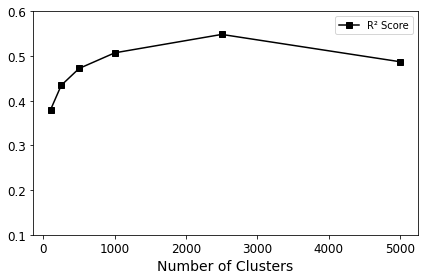

In [59]:
# Compute the R2 score
total_inertia = np.var(X_scaled, axis=0).sum()
intra_inertia = [model.inertia_/len(X_scaled)
                 for model in kmeans_per_k]
r2_scores = [1 - inertia/total_inertia
             for inertia in intra_inertia]

# Create the plot
plt.plot((100, 250, 500, 1000, 2500, 5000),
         r2_scores, "ks-", label="R² Score")
plt.xlabel("Number of Clusters")
plt.ylim(.1, .6)
plt.legend()
save_fig("scores_vs_k_plot_vwords")
plt.show()

Best results are obtained with $k=500$. We just need to replace each descriptors by k-means labels to get visual words.

In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans

def get_vwords(dic_desc, n_clusters=500):
    """Function to get visual words of images
    after computing SIFT descriptors.
    -----------
    Parameters:
    dic_desc: dict
        dict of image SIFT descriptors
    n_clusters: int, default 500
        The number of visual words to form
    -----------
    Return : a dictionnary with visual words for each image
    """
    # Concatenate all descriptors
    img_list = [key for key in dic_desc.keys()]
    X = np.concatenate([dic_desc[img]
                        for img in img_list])
    print(X.shape)
    # Scale data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # get labels
    model = MiniBatchKMeans(n_clusters, random_state=42)
    model.fit(X_scaled)
    labels = model.labels_
    # get visual words for each image
    dic_vwords = {}
    i = 0
    for img in img_list:
        n = dic_desc[img].shape[0]
        dic_vwords[img] = labels[i: i+n]
        i += n
    return dic_vwords

#### Visual Words histogram

The bag-of-features are obtained by computing the visual words histogram for all images. This histogram must be normalized, we will use the L2 norm. 

In [56]:
def get_vwords_hist(dic_vwords, n_clusters=500):
    """Function to get the normalized Histogram of visual words.
    The L2 norm is udes to normalize.
    -----------
    Parameters:
    dic_vwords: dict
        dict of image visual words
    n_clusters: int, default 500
        The number of visual words to form
    -----------
    Return : a dictionnary with bag-of-features vector for each image
    """
    img_list = [key for key in dic_vwords.keys()]
    # get bag-of-features
    dic_bof = {}
    for img in img_list:
        hist, bins_edges = np.histogram(dic_vwords[img], bins=n_clusters)
        x = hist.reshape((1, -1))
        # Use L2 norm to normalize data
        x = x / np.linalg.norm(x)
        dic_bof[img] = x
    return dic_bof

#### bag-of-features pipeline

In [57]:
def bof_pipeline(file_list, gray=True, model=0, n_clusters=500):
    """Pipeline to get bag of features from image.
    -----------
    Parameters:
    file_list: list
        list of image file to be opened
    gray: bool, default False
        If True, use grayscale image
    model: {0 or 'SIFT', 1 or 'ORB'}, default 0
        The model to be used    
    n_clusters: int, default 500
        The number of visual words to form
    -----------
    Return : an array with all bag of feaures
    """
    dic_desc = img_desc(file_list, gray, model)
    dic_vw = get_vwords(dic_desc, n_clusters)
    dic_bof = get_vwords_hist(dic_vw, n_clusters)
    return np.concatenate([dic_bof[img] for img in file_list])

In [58]:
file_list = ["data/Flipkart/Images/" + data.image[idx]
             for idx in data.index]

X_bof = bof_pipeline(file_list)

The SIFT algorithm has been used
Grayscale has been used for images
(5977613, 128)


All images have been encoded by a bag a features. Let's use a clustring algorithm to get the category of each product based on the encoded images.

### Images clustering

We will start with a K-Means. No need to scale data as they have already been normalized.

In [59]:
# Train the K-Means
kmeans_bof = KMeans(n_clusters=7, random_state=42)
labels_km_bof = kmeans_bof.fit(X_bof).labels_
# Assign each cluster with a category
dic_km_bof = assign_cluster(labels_km_bof)
# Get the confusion matrix
confusion_matrix_tuned(dic_km_bof, labels_km_bof)

accuracy: 0.29933269780743565
recall: 0.29933269780743565
precision: 0.2917295976715791


,Baby Care_pred,Beauty and Personal Care_pred,Computers_pred,Home Decor & Festive Needs_pred,Home Furnishing_pred,Kitchen & Dining_pred,Watches_pred
Baby Care_true,28,4,49,8,39,8,14
Beauty and Personal Care_true,14,31,21,8,33,14,29
Computers_true,9,11,84,6,6,20,13
Home Decor & Festive Needs_true,9,25,10,18,66,6,16
Home Furnishing_true,15,18,22,5,74,8,8
Kitchen & Dining_true,16,19,37,6,21,21,30
Watches_true,13,28,30,4,6,11,58


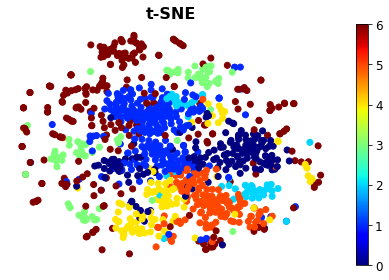

In [60]:
# Train the t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
X_tsne = tsne.fit_transform(X_bof)

# Plot results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_km_bof, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.title("t-SNE")
save_fig("t-SNE_plot")
plt.show()

Let's try now with the Ward model.

In [61]:
# Train the ward model
ward_bof = ward_model(X_bof, 7)
labels_ward_bof = ward_bof.fit(X_bof).labels_
# Assign each cluster with a category
dic_ward_bof = assign_cluster(labels_ward_bof)
# Get the confusion matrix
confusion_matrix_tuned(dic_ward_bof, labels_ward_bof)

accuracy: 0.30123927550047663
recall: 0.30123927550047663
precision: 0.22978149823255353


,Baby Care_pred,Beauty and Personal Care_pred,Computers_pred,Home Decor & Festive Needs_pred,Home Furnishing_pred,Kitchen & Dining_pred,Watches_pred
Baby Care_true,0,47,57,13,23,0,10
Beauty and Personal Care_true,0,72,21,41,11,0,5
Computers_true,0,25,86,21,1,0,16
Home Decor & Festive Needs_true,0,37,9,54,38,0,12
Home Furnishing_true,0,38,28,24,54,0,6
Kitchen & Dining_true,0,47,42,33,9,0,19
Watches_true,0,28,27,40,5,0,50


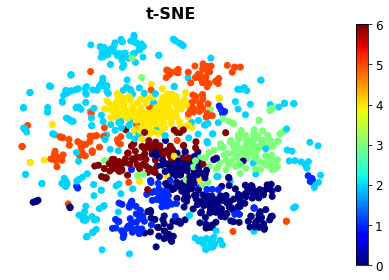

In [62]:
# Train the t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
X_tsne = tsne.fit_transform(X_bof)

# Plot results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_ward_bof, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.title("t-SNE")
save_fig("t-SNE_plot")
plt.show()

Both, k-means and Ward give poor results with SIFT (it is worse with ORB). Let's try another model based on neural networks: **VGG-16**.

### Tansfer learning

VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper *"Very Deep Convolutional Networks for Large-Scale Image Recoginition"*. It was used to win ILSVR (Imagenet) competition in 2014 and is still considered to be one of the best vision model architecture today.

![VGG16_Architecture](VGG16.png "VGG16 Architecture")
*VGG16 Architecture*

The input to cov1 layer is of fixed size 224 x 224 RGB image. The image is passed through a stack of thirteen convolutional (conv.) layers, where the filters were used with a very small receptive field: 3×3 (which is the smallest size to capture the notion of left/right, up/down, center).The convolution stride is fixed to 1 pixel; the spatial padding of conv. layer input is such that the spatial resolution is preserved after convolution, i.e. the padding is 1-pixel for 3×3 conv. layers. Spatial pooling is carried out by five max-pooling layers, which follow some of the conv.  layers (not all the conv. layers are followed by max-pooling). Max-pooling is performed over a 2×2 pixel window, with stride 2.  
Three Fully-Connected (FC) layers follow a stack of convolutional layers (which has a different depth in different architectures): the first two have 4096 channels each, the third performs 1000-way ILSVRC classification and thus contains 1000 channels (one for each class).  
All hidden layers are equipped with the *Rectified Linear Unit function (ReLU)* while the final layer used the *soft-max* activation function.

We do not have enough data to train such model, so we will use a pre-trained model to extract image features. Only the **first convolutional layers** will be used. As the idea is to use an unsupervised algorithm, no training will be performed. Consequently, it will be not a pure *Transfer Learning*.

Before using this pretrained model, some preprocessing is required. We need first to resize all images at 224 x 224, images will be cropped at the middle to preserve aspect ratios. Furthermore, the pretrained models assume that the images are preprocessed in a specific way. Thus, each model provides a `preprocess_input()` function to preprocess images. 

In [92]:
from PIL import ImageOps

dic_img = {}
for file in file_list:
    img = Image.open(file)
    img_resized = ImageOps.fit(img,
                               size=(224, 224),
                               method=Image.ANTIALIAS)
    img_resized = np.array(img_resized)
    dic_img[file] = img_resized
images = np.array([dic_img[file] for file in file_list])
images.shape

(1049, 224, 224, 3)

In [93]:
from tensorflow.keras.applications.vgg16 import preprocess_input

images = preprocess_input(images)

Let's apply the VGG-16 model.

In [94]:
from tensorflow.keras.applications.vgg16 import VGG16

# Load the VGG-16 model
model = VGG16(weights="imagenet", include_top=False)

In [96]:
X_vgg = model.predict(images)
X_vgg = X_vgg.reshape(1049, -1)
print(X_vgg.shape)

(1049, 25088)


25,088 features is too much, let's use a k-means to reduce that number at 300 (like the Work2Vec dimension).

In [97]:
kmeans = KMeans(n_clusters=300, random_state=42)
X_vgg_tr = kmeans.fit_transform(X_vgg)

Let's apply a clustering on it.

In [106]:
# Scale data
scaler = StandardScaler()
X_vgg_scaled = scaler.fit_transform(X_vgg_tr)
# Train the K-Means
kmeans_vgg = KMeans(n_clusters=7, random_state=42)
labels_km_vgg = kmeans_vgg.fit(X_vgg_scaled).labels_
# Assign each cluster with a category
dic_km_vgg = assign_cluster(labels_km_vgg)
# Get the confusion matrix
confusion_matrix_tuned(dic_km_vgg, labels_km_vgg)

accuracy: 0.32507149666348906
recall: 0.32507149666348906
precision: 0.23361749046664648


,Baby Care_pred,Beauty and Personal Care_pred,Computers_pred,Home Decor & Festive Needs_pred,Home Furnishing_pred,Kitchen & Dining_pred,Watches_pred
Baby Care_true,61,0,54,35,0,0,0
Beauty and Personal Care_true,58,0,31,56,0,0,5
Computers_true,50,0,77,22,0,0,0
Home Decor & Festive Needs_true,48,0,16,82,0,0,4
Home Furnishing_true,51,0,46,53,0,0,0
Kitchen & Dining_true,56,0,37,53,0,0,4
Watches_true,11,0,5,13,0,0,121


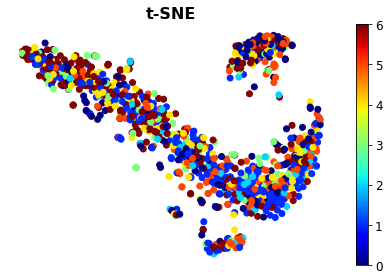

In [105]:
# Train the t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
X_tsne = tsne.fit_transform(X_vgg_scaled)

# Plot results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_km_bof, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.title("t-SNE")
save_fig("t-SNE_plot")
plt.show()

In [108]:
# Train the ward model
ward_vgg = ward_model(X_vgg_scaled, 7)
labels_ward_vgg= ward_vgg.fit(X_vgg_scaled).labels_
# Assign each cluster with a category
dic_ward_vgg = assign_cluster(labels_ward_vgg)
# Get the confusion matrix
confusion_matrix_tuned(dic_ward_vgg, labels_ward_vgg)

accuracy: 0.34509056244041947
recall: 0.34509056244041947
precision: 0.29601127930160587


,Baby Care_pred,Beauty and Personal Care_pred,Computers_pred,Home Decor & Festive Needs_pred,Home Furnishing_pred,Kitchen & Dining_pred,Watches_pred
Baby Care_true,0,0,86,17,46,0,1
Beauty and Personal Care_true,0,6,43,36,65,0,0
Computers_true,0,0,105,15,29,0,0
Home Decor & Festive Needs_true,0,2,36,50,59,0,3
Home Furnishing_true,0,0,61,22,67,0,0
Kitchen & Dining_true,0,4,55,43,48,0,0
Watches_true,0,5,7,4,0,0,134


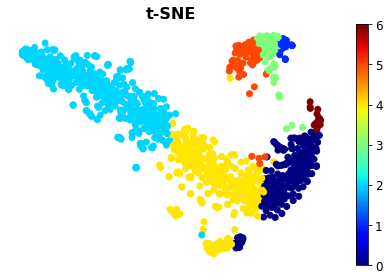

In [109]:
# Plot results
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_ward_vgg, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.title("t-SNE")
save_fig("t-SNE_plot")
plt.show()

It looks much better.

## Clustering with all data

blabla

blabla